In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle
from pathlib import Path
from importlib import reload
from IPython.display import clear_output

import IEFC_modules.iefc_simulation as iefc
from IEFC_modules import iefc_functions
reload(iefc)


import roman
import misc

wavelength_c = 575e-9*u.m

wavelength_ref = 0.5e-6*u.m
pixelscale_lamD_ref = 1/2
pixelscale_ref = 13e-6*u.m/u.pix
pixelscale_lamD = pixelscale_lamD_ref * (wavelength_ref/wavelength_c)
print(pixelscale_lamD)

wavelength = 575e-9*u.m
npsf = 64
psf_pixelscale = 13e-6*u.m/u.pix
# npsf = 256
# psf_pixelscale = 2.9587987694e-6*u.m/u.pix
psf_pixelscale_lamD = pixelscale_lamD * (psf_pixelscale/pixelscale_ref)
print(psf_pixelscale_lamD)

Nact = 48
dm_diam = 46.3*u.mm
act_spacing = 0.9906*u.mm


0.43478260869565216
0.43478260869565216


Propagating wavelength 575.000 nm.
PSF calculated in 6.56s


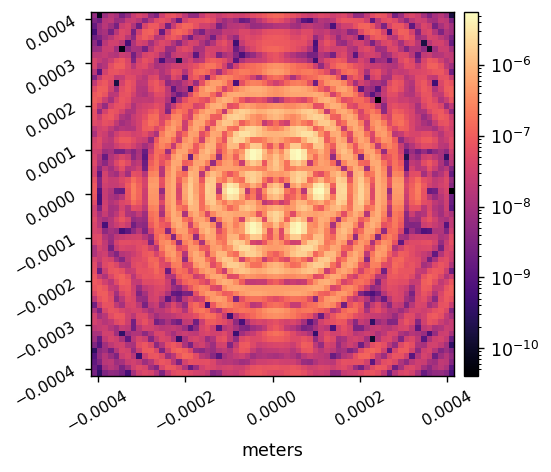

In [5]:
reload(roman)

hlci = roman.CGI(quiet=False)
psf = hlci.calc_psf()

misc.myimshow(psf, lognorm=True, pxscl=hlci.psf_pixelscale)

In [6]:
reload(roman)

hlci = roman.CGI(quiet=False)
# hlci.DM1.set_surface(np.ones((48,48)))

dm1s = [np.zeros((48,48)), np.zeros((48,48)), np.zeros((48,48)), np.zeros((48,48)), 
        np.zeros((48,48)), np.zeros((48,48)), np.zeros((48,48)), np.zeros((48,48))]
dm2s = [np.zeros((48,48)), np.zeros((48,48)), np.zeros((48,48)), np.zeros((48,48)), 
        np.zeros((48,48)), np.zeros((48,48)), np.zeros((48,48)), np.zeros((48,48))]

%timeit hlci.calc_psfs(dm1s, dm2s)


Running mode HLC575 for multiple DM settings.
Propagating wavelength 575.000 nm.
PSF calculated in 6.84s
Propagating wavelength 575.000 nm.
PSF calculated in 6.87s
Propagating wavelength 575.000 nm.
PSF calculated in 6.94s
Propagating wavelength 575.000 nm.
PSF calculated in 6.97s
Propagating wavelength 575.000 nm.
PSF calculated in 7.00s
Propagating wavelength 575.000 nm.
PSF calculated in 7.00s
Propagating wavelength 575.000 nm.
PSF calculated in 7.13s
Propagating wavelength 575.000 nm.
PSF calculated in 7.14s
Running mode HLC575 for multiple DM settings.
Propagating wavelength 575.000 nm.
PSF calculated in 6.77s
Propagating wavelength 575.000 nm.
PSF calculated in 6.79s
Propagating wavelength 575.000 nm.
PSF calculated in 6.81s
Propagating wavelength 575.000 nm.
PSF calculated in 6.77s
Propagating wavelength 575.000 nm.
PSF calculated in 6.92s
Propagating wavelength 575.000 nm.
PSF calculated in 6.81s
Propagating wavelength 575.000 nm.
PSF calculated in 6.97s
Propagating wavelength 

# Create dark hole ROI to calibrate and control

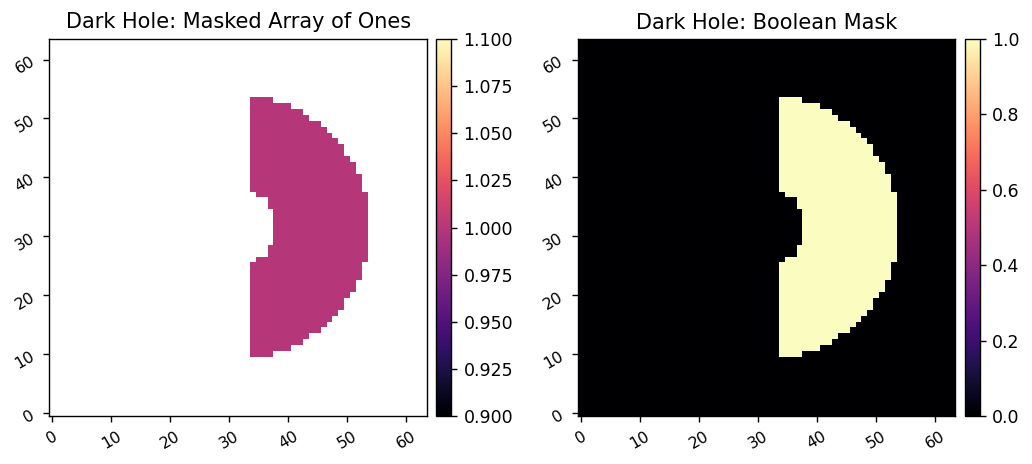

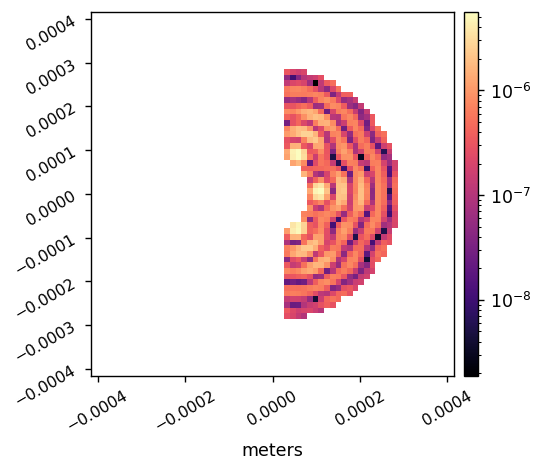

In [7]:
# set dark hole ROI (only annular dark-holes supported for now)
iwa = 2.8*psf_pixelscale/psf_pixelscale_lamD
owa = 9.7*psf_pixelscale/psf_pixelscale_lamD
roi_side = 'right'
roi_offset = 1*psf_pixelscale/psf_pixelscale_lamD

roi_mask = misc.create_annular_roi_mask(npsf, psf_pixelscale, iwa, owa, side=roi_side, offset=roi_offset)

misc.myimshow2(roi_mask, ~roi_mask.mask, 'Dark Hole: Masked Array of Ones', 'Dark Hole: Boolean Mask')
misc.myimshow(psf*roi_mask, lognorm=True, pxscl=hlci.psf_pixelscale)

(4096,) (4096,) (4096,)


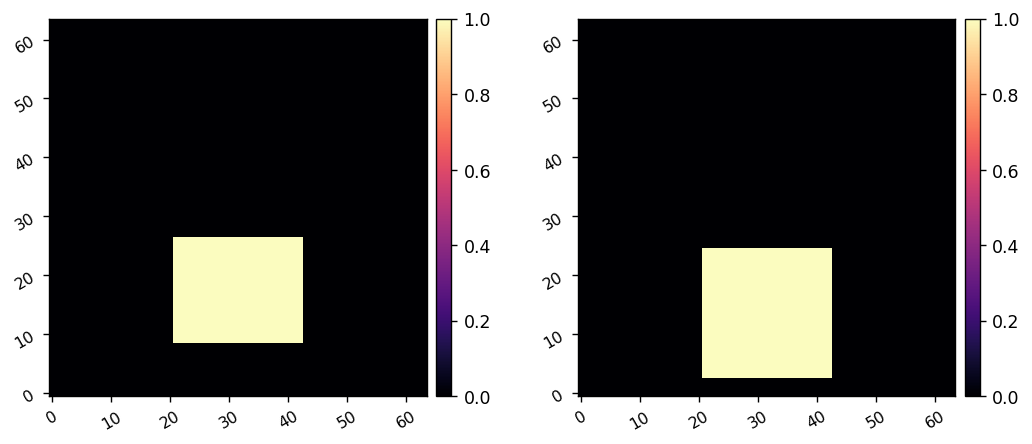

(4096,)


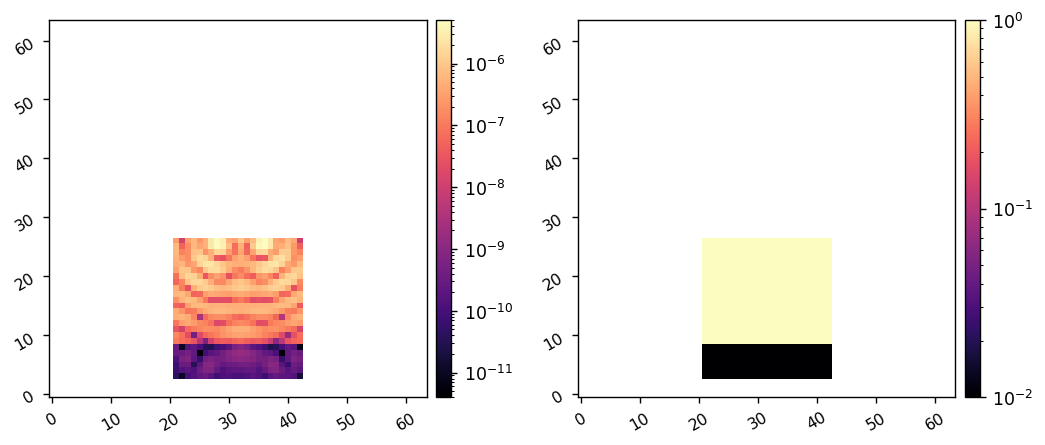

In [8]:
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

# Create the mask that is used to select which region to make dark.
dh_params = {
    'x0' : 0,
    'y0' : -6,
    'w' : 10,
    'h' : 8
}
dh_mask = iefc_functions.create_box_focal_plane_mask(xf, yf, dh_params['x0'], dh_params['y0'], 
                                                     dh_params['w'], dh_params['h']).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'x0' : 0,
    'y0' : -8,
    'w' : 10,
    'h' : 10
}
control_mask = iefc_functions.create_box_focal_plane_mask(xf, yf, control_params['x0'], control_params['y0'], 
                                                          control_params['w'], control_params['h']).ravel()
full_mask = control_mask * (abs(yf).ravel()>0.5)

print(dh_mask.shape, control_mask.shape, full_mask.shape)
misc.myimshow2(dh_mask.reshape(npsf,npsf), full_mask.reshape(npsf,npsf))

# Create the control matrix
relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * full_mask
# weights = roi_mask * relative_weight + (1 - relative_weight) * roi_mask

print(weights.shape)
misc.myimshow2(psf*weights.reshape(npsf,npsf), weights.reshape(npsf,npsf), lognorm1=True, lognorm2=True)

# Create probe and fourier modes

Createing Fourier modes:  (64, 64)
(242, 2304) (2, 2304)


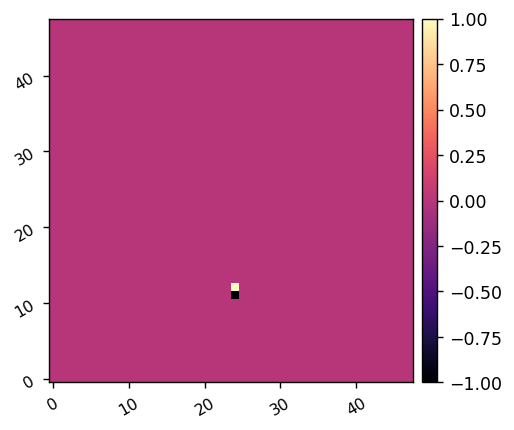

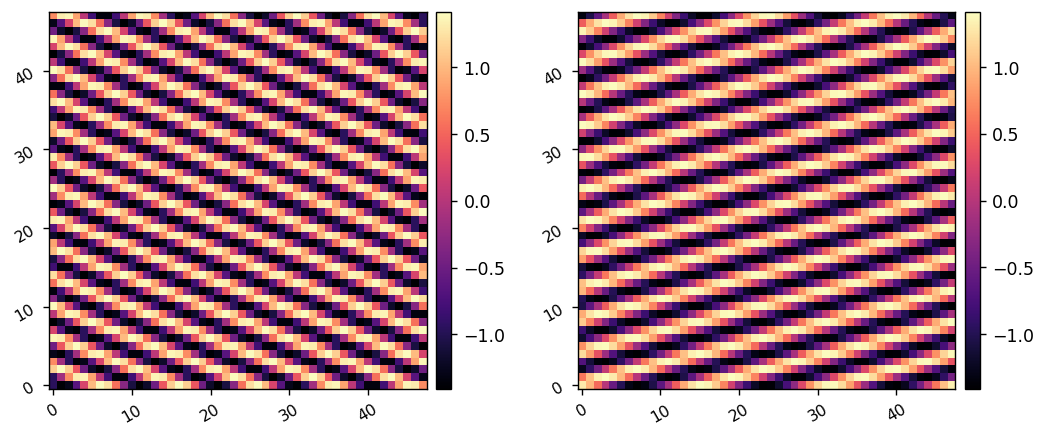

In [9]:
# fourier_modes, fx, fy = iefc.create_fourier_modes(xfp, ~roi_mask.mask, Nact=Nact)
# probe_modes = iefc.create_probe_poke_modes(Nact, Nact//2, Nact//4, Nact//2, Nact//4-1)
fourier_modes, fx, fy = iefc.create_fourier_modes(xfp, control_mask.reshape((npsf,npsf)), Nact)
probe_modes = iefc.create_probe_poke_modes(Nact, Nact//2, Nact//4, Nact//2, Nact//4-1)

probe_amplitude = 0.05 * wavelength.to(u.m).value
calibration_amplitude = 0.006 * wavelength.to(u.m).value

print(fourier_modes.shape, probe_modes.shape)
misc.myimshow((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)))
misc.myimshow2(fourier_modes[0].reshape((Nact,Nact)), fourier_modes[140].reshape((Nact,Nact)))

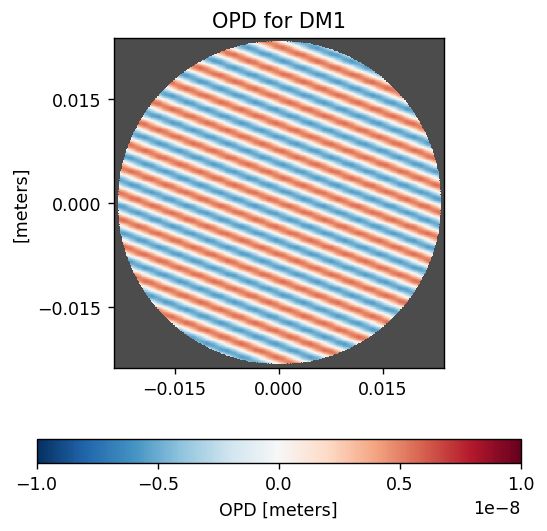

Running mode HLC575 for multiple DM settings.
Propagating wavelength 575.000 nm.
PSF calculated in 6.91s
Propagating wavelength 575.000 nm.
PSF calculated in 6.95s
Propagating wavelength 575.000 nm.
PSF calculated in 7.16s
Propagating wavelength 575.000 nm.
PSF calculated in 7.16s
(2, 4096) (4, 4096)


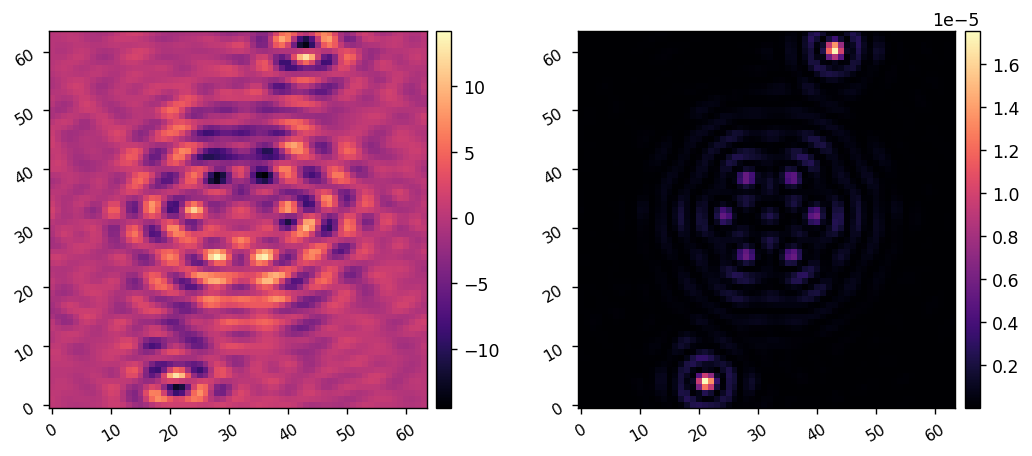

In [8]:
reload(roman)

hlci = roman.CGI(quiet=False)
hlci.add_dm1(calibration_amplitude * fourier_modes[0])

misc.display_dm(hlci.DM1, vmax=1e-8)

differential_images, single_images = iefc.take_measurement(hlci, probe_modes, probe_amplitude, return_all=True)

print(differential_images.shape, single_images.shape)
misc.myimshow2(differential_images[1].reshape((64,64)), single_images[3].reshape((64,64)))

# Calibrate IEFC (or load in previous calibration data)

In [9]:
reload(iefc)

hlci = roman.CGI(cgi_mode='hlc')
response_cube, calibration_cube = iefc.calibrate(hlci, probe_amplitude, probe_modes, 
                                                 calibration_amplitude, fourier_modes, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 242 in 19.969s
	Calibrated mode 2 / 242 in 39.063s
	Calibrated mode 3 / 242 in 59.173s
	Calibrated mode 4 / 242 in 78.787s
	Calibrated mode 5 / 242 in 98.227s
	Calibrated mode 6 / 242 in 117.987s
	Calibrated mode 7 / 242 in 138.146s
	Calibrated mode 8 / 242 in 159.237s
	Calibrated mode 9 / 242 in 178.942s
	Calibrated mode 10 / 242 in 199.152s
	Calibrated mode 11 / 242 in 218.661s
	Calibrated mode 12 / 242 in 238.132s
	Calibrated mode 13 / 242 in 257.954s
	Calibrated mode 14 / 242 in 277.689s
	Calibrated mode 15 / 242 in 297.697s
	Calibrated mode 16 / 242 in 317.572s
	Calibrated mode 17 / 242 in 337.150s
	Calibrated mode 18 / 242 in 356.979s
	Calibrated mode 19 / 242 in 376.788s
	Calibrated mode 20 / 242 in 396.370s
	Calibrated mode 21 / 242 in 415.990s
	Calibrated mode 22 / 242 in 435.814s
	Calibrated mode 23 / 242 in 455.527s
	Calibrated mode 24 / 242 in 475.397s
	Calibrated mode 25 / 242 in 495.118s
	Calibrated mode 26 / 242 in 514.679s
	Cali

	Calibrated mode 210 / 242 in 4159.854s
	Calibrated mode 211 / 242 in 4179.588s
	Calibrated mode 212 / 242 in 4199.058s
	Calibrated mode 213 / 242 in 4218.970s
	Calibrated mode 214 / 242 in 4238.884s
	Calibrated mode 215 / 242 in 4258.628s
	Calibrated mode 216 / 242 in 4278.646s
	Calibrated mode 217 / 242 in 4298.446s
	Calibrated mode 218 / 242 in 4317.764s
	Calibrated mode 219 / 242 in 4337.926s
	Calibrated mode 220 / 242 in 4361.402s
	Calibrated mode 221 / 242 in 4380.714s
	Calibrated mode 222 / 242 in 4400.563s
	Calibrated mode 223 / 242 in 4420.411s
	Calibrated mode 224 / 242 in 4440.030s
	Calibrated mode 225 / 242 in 4459.697s
	Calibrated mode 226 / 242 in 4479.543s
	Calibrated mode 227 / 242 in 4499.189s
	Calibrated mode 228 / 242 in 4519.048s
	Calibrated mode 229 / 242 in 4538.777s
	Calibrated mode 230 / 242 in 4558.508s
	Calibrated mode 231 / 242 in 4579.204s
	Calibrated mode 232 / 242 in 4598.919s
	Calibrated mode 233 / 242 in 4618.144s
	Calibrated mode 234 / 242 in 4638.427s


In [10]:
print(response_cube.shape, calibration_cube.shape)

response_hdu = fits.PrimaryHDU(data=response_cube)
response_hdu.writeto(Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data/response_cube_box_mask.fits'), overwrite=True)

calib_hdu = fits.PrimaryHDU(data=calibration_cube)
calib_hdu.writeto(Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration_cube_box_mask.fits'), overwrite=True)

(242, 2, 4096) (484, 4, 4096)


In [10]:
response_cube = fits.getdata(Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data/response_cube_box_mask.fits'))
calibration_cube = fits.getdata(Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration_cube_box_mask.fits'))

# Filter calibration data

In [11]:
# Filter the calibration files by subtracting PCA modes
npca = 3
filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

# Create control matrix

In [12]:

control_matrix = iefc.construct_control_matrix(filtered_response_cube, 
                                               weights.flatten(), rcond=3e-4, pca_modes=pca_modes)


# Run IEFC

Closed-loop iteration 1 / 5
Running mode HLC575 for multiple DM settings.
Propagating wavelength 575.000 nm.
PSF calculated in 6.73s
Propagating wavelength 575.000 nm.
PSF calculated in 6.81s
Propagating wavelength 575.000 nm.
PSF calculated in 6.82s
Propagating wavelength 575.000 nm.
PSF calculated in 6.86s
(242,)
(2304,)
Propagating wavelength 575.000 nm.
PSF calculated in 6.58s


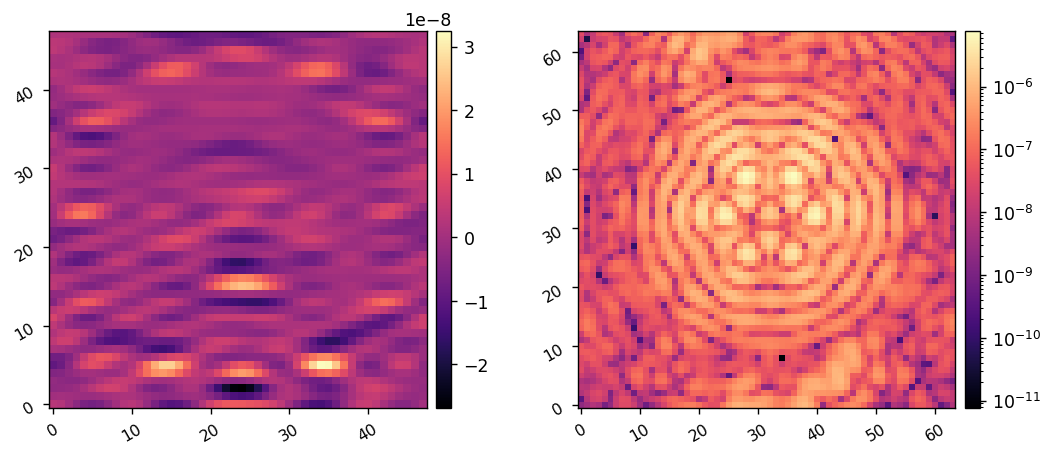

Closed-loop iteration 2 / 5
Running mode HLC575 for multiple DM settings.
Propagating wavelength 575.000 nm.
PSF calculated in 6.72s
Propagating wavelength 575.000 nm.
PSF calculated in 6.87s
Propagating wavelength 575.000 nm.
PSF calculated in 6.90s
Propagating wavelength 575.000 nm.
PSF calculated in 6.87s
(242,)
(2304,)
Propagating wavelength 575.000 nm.
PSF calculated in 6.55s


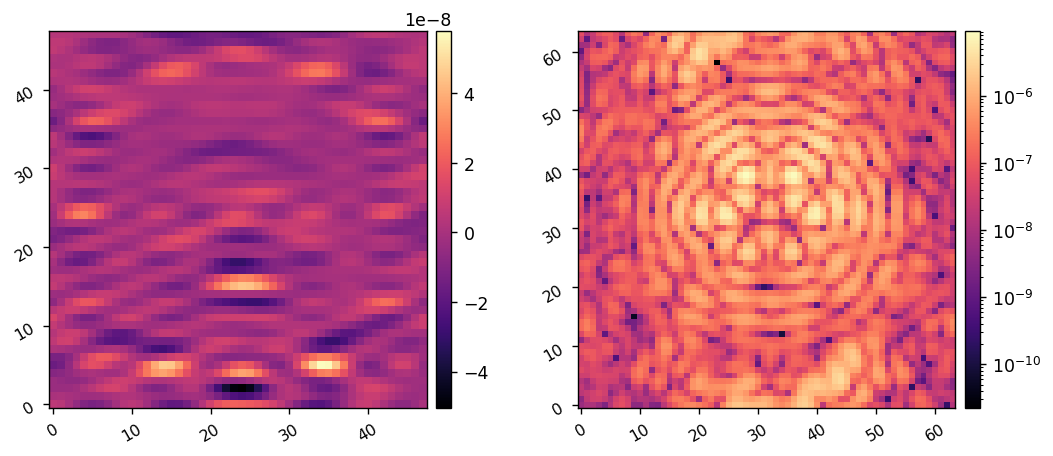

Closed-loop iteration 3 / 5
Running mode HLC575 for multiple DM settings.
Propagating wavelength 575.000 nm.
PSF calculated in 6.77s
Propagating wavelength 575.000 nm.
PSF calculated in 6.84s
Propagating wavelength 575.000 nm.
PSF calculated in 6.88s
Propagating wavelength 575.000 nm.
PSF calculated in 6.88s
(242,)
(2304,)
Propagating wavelength 575.000 nm.
PSF calculated in 6.57s


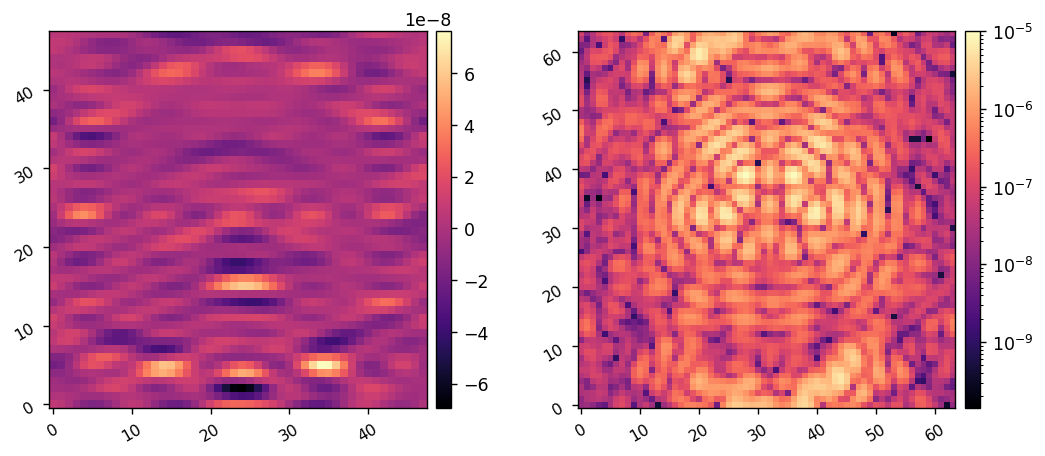

Closed-loop iteration 4 / 5
Running mode HLC575 for multiple DM settings.
Propagating wavelength 575.000 nm.
PSF calculated in 6.72s
Propagating wavelength 575.000 nm.
PSF calculated in 6.88s
Propagating wavelength 575.000 nm.
PSF calculated in 6.99s
Propagating wavelength 575.000 nm.
PSF calculated in 6.99s
(242,)
(2304,)
Propagating wavelength 575.000 nm.
PSF calculated in 6.60s


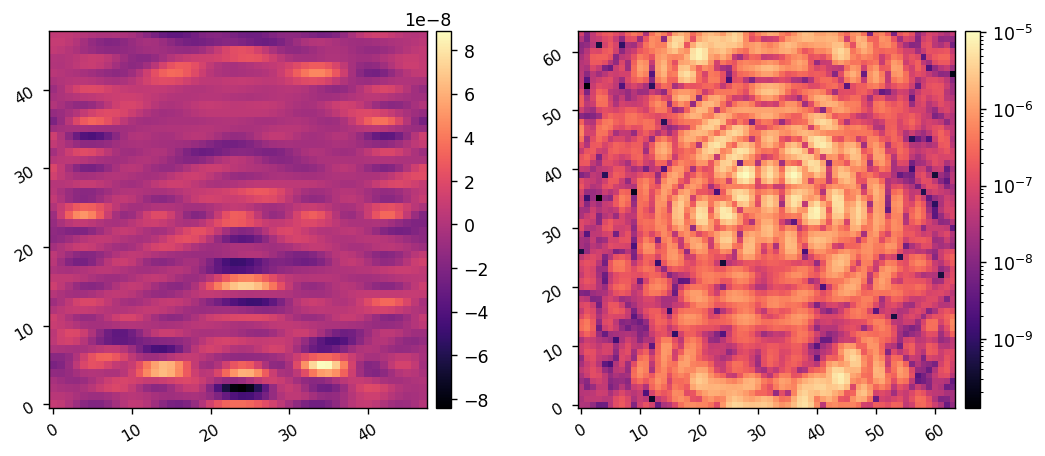

Closed-loop iteration 5 / 5
Running mode HLC575 for multiple DM settings.
Propagating wavelength 575.000 nm.
PSF calculated in 6.74s
Propagating wavelength 575.000 nm.
PSF calculated in 6.88s
Propagating wavelength 575.000 nm.
PSF calculated in 6.93s
Propagating wavelength 575.000 nm.
PSF calculated in 6.94s
(242,)
(2304,)
Propagating wavelength 575.000 nm.
PSF calculated in 6.58s


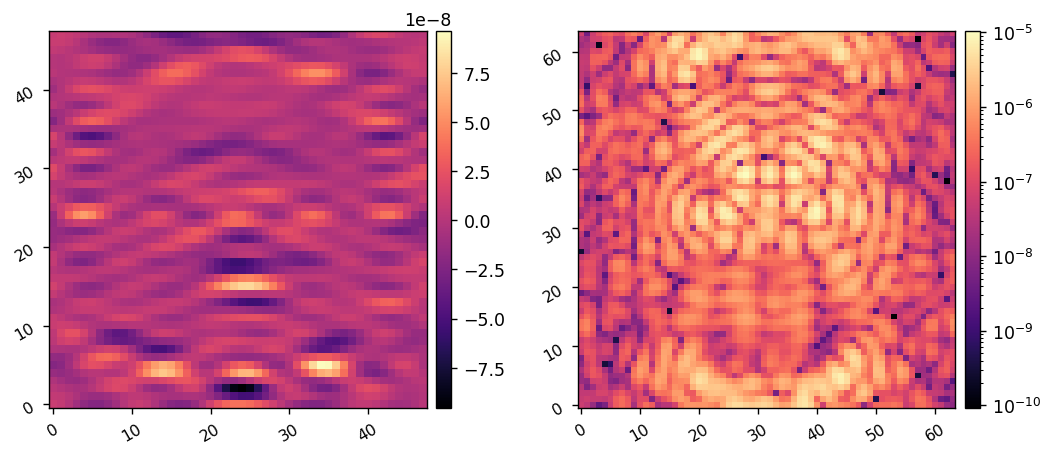

In [13]:
# The metric
metric_images = []
dm_commands = []
command = 0.0

## Run IEFC for num_iterations
num_iterations = 5
gain = -0.2
leakage = 0.0

for i in range(num_iterations):
    print("Closed-loop iteration {:d} / {:d}".format(i+1, num_iterations))
#     delta_coefficients = iefc_functions.IEFC_single_iteration(tbi, probe_modes, probe_amplitude, 
#                                                               control_matrix, weights>0)
    delta_coefficients = iefc.single_iteration(hlci, probe_modes, probe_amplitude, 
                                               control_matrix, weights.flatten()>0)
    print(delta_coefficients.shape)
    command = (1.0-leakage) * command + gain * delta_coefficients
    
    # Reconstruct the full phase from the Fourier modes
    dm_command = np.einsum('ij, i->j', fourier_modes, command)
    print(dm_command.shape)
    
    # Set the current DM state
#     tbi.set_dm(dm_command)
#     ret = tbi.send_dm()
    hlci.set_dm1(dm_command)
    
    # Take an image to estimate the metrics
#     metric_images.append(tbi.snap())
    image = hlci.calc_psf()
    metric_images.append(image)
    dm_commands.append(dm_command)
    
    misc.myimshow2(dm_command.reshape(Nact,Nact), image, lognorm2=True)
    pass

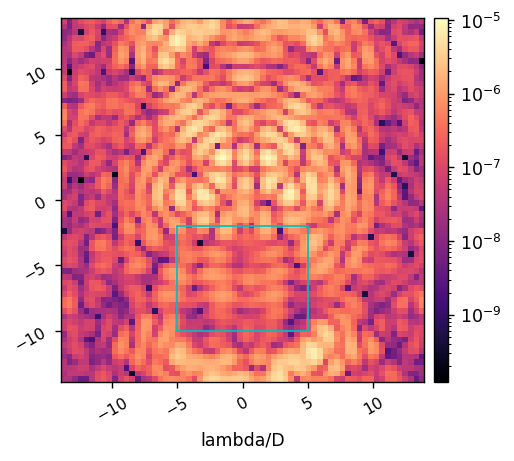

In [14]:
reload(iefc)

patches = [iefc.create_rect_patch(dh_params)] 
misc.myimshow(metric_images[3], lognorm=True, patches=patches, pxscl=psf_pixelscale_lamD.value)

# Testing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LogNorm
from matplotlib.animation import FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.ffmpeg_path'] ='/.../bin/ffmpeg.exe'
plt.rcParams['animation.convert_path'] = '/.../magick.exe'
plt.rcParams['animation.html'] = 'html5'

wfs_min, wfs_max = (1, 0)
for i in range(len(images)):
    m, M = ( np.min(images), np.max(images) )
    if m < wfs_min: wfs_min = m
    if M > wfs_max: wfs_max = M

fig,ax = plt.subplots(1,2, figsize=(10,4), dpi=100)

dm_ext = np.array([-Nacts/2, Nacts/2, -Nacts/2, Nacts/2])*hlci.act_spacing.value
psf_ext = np.array([-npsf/2, npsf/2, -npsf/2, npsf/2])*psf_pixelscale_lamD
    
ax0 = ax[0].imshow(actuators[0], cmap='magma', extent=dm_ext)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar0 = fig.colorbar(ax0, cax=cax)
ax0_title = ax[0].set_title('Iteration {:d}'.format(range(15)[0]), fontsize = 18)

ax1 = ax[1].imshow(images[0], norm=LogNorm(), cmap='gist_heat', extent=psf_ext)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar0 = fig.colorbar(ax1, cax=cax)
ax1_title = ax[1].set_title('PSF', fontsize = 18)
ax1.add_patch(iefc.create_rect_patch(dh_params))

plt.close()

def animate(i):
    ax0.set_data(actuators[i])
    ax0.set_clim(np.min(actuators[i]), np.max(actuators[i]))
    ax0_title.set_text('Iteration {:d}'.format(range(15)[i]))
    
    ax1.set_data(wavefronts[i][-1].intensity)
    ax1.set_clim(wfs_min, wfs_max)
    ax1.add_patch(iefc.create_rect_patch(dh_params))

anim = animation.FuncAnimation(fig, animate, frames=len(actuators))
anim

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LogNorm
from matplotlib.animation import FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.ffmpeg_path'] ='/.../bin/ffmpeg.exe'
plt.rcParams['animation.convert_path'] = '/.../magick.exe'
plt.rcParams['animation.html'] = 'html5'

wfs_min, wfs_max = (1, 0)
for i in range(len(wavefronts)):
    m, M = ( np.min(wavefronts[i][-1].intensity), np.max(wavefronts[i][-1].intensity) )
    if m < wfs_min: wfs_min = m
    if M > wfs_max: wfs_max = M

fig,ax = plt.subplots(1,2, figsize=(10,4), dpi=100)

dm_ext = np.array([-Nacts/2, Nacts/2, -Nacts/2, Nacts/2])*act_spacing.value
psf_ext = np.array([-npsf/2, npsf/2, -npsf/2, npsf/2])*wavefronts[0][-1].pixelscale.to(u.mm/u.pix).value
    
ax0 = ax[0].imshow(actuators[0], cmap='magma', extent=dm_ext)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar0 = fig.colorbar(ax0, cax=cax)
ax0_title = ax[0].set_title('Iteration {:d}'.format(range(15)[0]), fontsize = 18)

ax1 = ax[1].imshow(wavefronts[0][-1].intensity, norm=LogNorm(), cmap='gist_heat', extent=psf_ext)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar0 = fig.colorbar(ax1, cax=cax)
ax1_title = ax[1].set_title('PSF', fontsize = 18)
plt.close()

def animate(i):
    ax0.set_data(actuators[i])
    ax0.set_clim(np.min(actuators[i]), np.max(actuators[i]))
    ax0_title.set_text('Iteration {:d}'.format(range(15)[i]))
    
    ax1.set_data(wavefronts[i][-1].intensity)
    ax1.set_clim(wfs_min, wfs_max)
    ax1

anim = animation.FuncAnimation(fig, animate, frames=len(actuators))
anim
